In [623]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 9, 5

# Реалізація МНКО

In [624]:
def RMNK(X, y, s=None, sigma_estimation=None, verbose=False,
         deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, sigma_estimation,
                                     verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, sigma_estimation,
                                 verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,
                                           (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            if sigma_estimation is None:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
            else:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp_simple',
                                           'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        Cp_simple = RSS_next + 2 * m
        if sigma_estimation is None:
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp': Cp_simple, 'FPE': FPE},
                           ignore_index=True)
        else:
            Cp = RSS_next + 2 * sigma_estimation * m
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp_simple': Cp_simple,
                            'Cp': Cp, 'FPE': FPE},
                           ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

# Пошук моделі оптимальної складності

In [745]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 0.3
    s0 = 3
    s = m
    
    def __init__(self, m=None, s0=None, theta=None, a=None, b=None,
                 X=None, y=None):
        if m:
            self.m = m
            self.s = m
        if s0:
            self.s0 = s0
        if theta:
            if isinstance(theta, dict) and theta['random']:
                self.theta = np.zeros(self.m)
                self.theta[:self.s0] = np.random.uniform(*theta['random'],
                                                         size=self.s0)
            elif theta == 'unknown':
                assert X is not None, 'Please provide data (X)'
                assert y is not None, 'Please provide target values as well (y)'
                self.theta = theta
            else:
                self.theta = theta
        if a:
            self.a = a
        if b:
            self.b = b
        if X is not None:
            assert y is not None, 'Please provide target values as well (y)'
            self.X = np.array(X)
            self.y = np.array(y)
            (self.n, self.m) = X.shape
            self.s = self.m
        else:
            self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self, n=None, sigma=None):
        if n:
            self.n = n
        if sigma:
            self.sigma = sigma
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def show(self, n_limit=10):
        print('Regressors: m = {}'.format(self.m))
        print('True parameters: θ = {}'.format(self.theta))
        if not isinstance(self.theta, str):
            equation_str = ''
            for i, theta_i in enumerate(self.theta):
                equation_str += ' + ({}) * x{}'.format(theta_i, i+1)
            equation_str = 'y0 = '+ equation_str[3:]
            print(equation_str)
            print('Noise generation: σ = {}'.format(self.sigma))
        print('Sample length: n = {}'.format(self.n))
        print('X[:10]:\n{}'.format(self.X[:n_limit]))
        print('y[:10]:\n{}'.format(self.y[:n_limit]))
        
    def show_estimations(self):
        print('RSS(m) = {:5.5}'.format(self.RSS))
        print('σ* = {:5.5}'.format(self.sigma_hat ** .2))
    
    def estimate_sigma(self):
        _, _, self.RSS = RMNK(self.X, self.y, s=self.s,
                         verbose=False, create_dataframe=False)
        self.sigma_hat = self.RSS ** 2 / (self.X.shape[0] - self.X.shape[1])
        
    def run_grid_RMNK_model_selection(self):
        self.estimate_sigma()
        for i, n in enumerate(self.n_grid): 
            for j, sigma in enumerate(self.sigma_grid):
                self.compile(n, sigma)
                print('--------------------------------------------------------------')
                print('\t\t\tSAMPLE #{}'.format(i * len(self.n_grid) + j + 1))
                print('--------------------------------------------------------------')
                print('\t\tCONFUGURATIONS & DATA')
                self.show()
                print('\n\t\tRLSM ITERATIONS')
                theta_pred, _, _, df = RMNK(self.X, self.y, s=self.s,
                                            verbose=True, create_dataframe=True)
                print('\n\t\t\tRESULTS')
                print('\nPARAMETERS')
                print('True values:\tθ: {}'.format(self.theta))
                print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
                plt.plot(df['s'], df['RSS'], label='RSS')
                plt.plot(df['s'], df['Cp'], label='Cp')
                plt.plot(df['s'], df['FPE'], label='FPE')
                plt.legend()
                plt.show()
                print(df)
                print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
                print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
                print()
    
    def run_single_RMNK_model_selection(self, p=None, plot=False, 
                                        criteria=['Cp', 'FPE', 'RSS']):
        """Single RMNK
        
        p : str in ['direct', 'reverse', 'correlation'] or list
            if list: permutation indices
            if str: how to create permutation
        """
        if p == 'reverse':
            print('=============\nREVERSE\n=============')
            p = np.flip(np.arange(self.m), axis=0)
        elif p == 'correlation':
            print('=====================\nCORRELATION INCLUDING\n=====================')
            correlations = np.abs(np.cov(self.X.T, self.y.T)[-1,:-1])
            p = np.argsort(-correlations)
        elif isinstance(p, list):
            print('=============\nCUSTOM\n=============')
        else:
            print('=============\nDIRECT\n=============')
            p = np.arange(self.m)
        print('Regressors order: {}'.format(p))
        theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=self.s,
                                    verbose=False, create_dataframe=True)
            
        df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
        for criterion in criteria:
            df[criterion] = np.round(df[criterion], 6)
        if plot:
            for criterion in criteria:
                plt.plot(df['s'], df[criterion], label=criterion)
                plt.legend()
                plt.show()
        df = df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        self.s_opt, self.regressors_opt = df.loc[0, ['s','regressors']]
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return df
    
    def run_single_full_RMNK_model_selection(self,
                                             criteria=['Cp', 'FPE', 'RSS']):
        print('=============\nBRUT FORCE\n=============')
        total_df = pd.DataFrame()
        for p in permutations(range(self.m)):
            p = np.array(p)
            theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            total_df = pd.concat([total_df, df], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        return total_df
    
    def run_single_random_RMNK_model_selection(self, K=20,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nRANDOM INCLUDING WITH K = {}\n================================'.format(K))
        permutations = [np.random.permutation(self.m) for k in range(K)]
        total_df = pd.DataFrame()
        best_df = pd.DataFrame()
        self.main_criterion_value = np.Inf
        for p in permutations:
            p = np.array(p)
            theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            df = df.sort_values(by=criteria).reset_index()
            main_criterion_value = df.loc[0, main_criterion]
            if main_criterion_value < self.main_criterion_value:
                self.main_criterion_value = main_criterion_value
                self.theta_pred = theta_pred
                self.s_opt, self.regressors_opt = df.loc[0,
                                                         ['s', 'regressors']]
            total_df = pd.concat([total_df, df], axis=0)
            best_df = pd.concat([best_df, df.loc[0:0]], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print()
        print(best_df[:5])
        print('...')
        print(best_df[-5:])
        print()
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return total_df, best_df
    
    def run_single_picking_RMNK_model_selection(self,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nPICKING INCLUDING\n================================'.format(K))
        total_df = pd.DataFrame()
        best_df = pd.DataFrame()
        self.main_criterion_value = np.Inf
        remained_indices = list(range(self.m))
        regressors_indices = []
        while len(remained_indices) > 0:
            local_main_criterion_value = np.Inf
            for i in remained_indices:
                p = np.array(regressors_indices + [i])
                theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=len(p),
                                            verbose=False, create_dataframe=True)
                df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
                df = df.sort_values(by=criteria).reset_index()
                main_criterion_value = df.loc[0, main_criterion]
                if main_criterion_value < local_main_criterion_value:
                    local_main_criterion_value = main_criterion_value
                    local_df = df[:1]
                    local_i = i
                if main_criterion_value < self.main_criterion_value:
                    self.main_criterion_value = main_criterion_value
                    self.theta_pred = theta_pred
                    self.s_opt, self.regressors_opt = df.loc[0, ['s', 'regressors']]
                total_df = pd.concat([total_df, df], axis=0)
            regressors_indices += [local_i]
            remained_indices.remove(local_i)
            best_df = pd.concat([best_df, local_df], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates().reset_index()\
                   [['s', 'regressors'] + criteria]
#         total_df = total_df.sort_values(by=criteria).reset_index()\
#                    [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return total_df, best_df

## Задання конфігурацій. Створення вибірок

### Тест 1 (вибірка аналогічна вибірці з лабораторної роботи №2)

In [761]:
config1 = ModelConfig(a=0, b=0.5)
config1.compile(n=1000)
config1.generate_noise_and_output()
config1.show()

Regressors: m = 5
True parameters: θ = [ 3 -2  1  0  0]
y0 = (3) * x1 + (-2) * x2 + (1) * x3 + (0) * x4 + (0) * x5
Noise generation: σ = 0.3
Sample length: n = 1000
X[:10]:
[[0.04308385 0.27830758 0.26976892 0.39022119 0.49445485]
 [0.35547599 0.48728023 0.29090938 0.17106778 0.44217748]
 [0.23057501 0.05182741 0.35420655 0.33878025 0.43994632]
 [0.09611698 0.12839818 0.18620192 0.42063433 0.26173627]
 [0.091473   0.05942291 0.3604472  0.34968361 0.32910679]
 [0.24643068 0.33150797 0.28024961 0.49592521 0.12985612]
 [0.13910572 0.15118726 0.38102016 0.14029001 0.39970713]
 [0.06306985 0.27847968 0.31756348 0.40461903 0.25243815]
 [0.11870129 0.4192407  0.32457993 0.18718059 0.38507428]
 [0.41681015 0.03932334 0.11500753 0.00913267 0.04140103]]
y[:10]:
[-0.43291385  0.38575983  1.06335113  0.12211829  0.61379791  0.46785321
  1.26450697  0.12539443  0.04208874  1.33072653]


### Тест 2 (велика вибірка з великою кількістю регресорів)

In [762]:
config2 = ModelConfig(m=15, s0=10, a=0, b=0.5, theta={'random': [1, 10]})
config2.compile(n=1000)
config2.generate_noise_and_output()
config2.show(5)

Regressors: m = 15
True parameters: θ = [1.6112567  3.92918486 5.54550484 8.89579123 5.61658096 1.80037743
 1.31102406 4.00562737 7.73951187 8.13889251 0.         0.
 0.         0.         0.        ]
y0 = (1.6112567036457572) * x1 + (3.929184861555827) * x2 + (5.545504835204717) * x3 + (8.895791227491983) * x4 + (5.616580955720129) * x5 + (1.800377427691979) * x6 + (1.311024062705871) * x7 + (4.005627372238807) * x8 + (7.739511870641742) * x9 + (8.138892514210113) * x10 + (0.0) * x11 + (0.0) * x12 + (0.0) * x13 + (0.0) * x14 + (0.0) * x15
Noise generation: σ = 0.3
Sample length: n = 1000
X[:10]:
[[0.17141608 0.08781483 0.01743464 0.29952731 0.16745103 0.24753049
  0.1284215  0.38092612 0.3119313  0.3007671  0.17271201 0.19120914
  0.29735522 0.44397982 0.4809952 ]
 [0.47869302 0.15824631 0.0570476  0.4013738  0.4536813  0.33610225
  0.07485632 0.24895821 0.18230803 0.14178467 0.32708787 0.2305085
  0.48024906 0.24493323 0.38827829]
 [0.0131716  0.36956987 0.13101176 0.37314593 0.10267

### Тест 3 (власні задачі)

#### Діабет

Для 442 пацієнтів з діабетом, маємо 10 вхідних змінних:
- вік
- стать
- індекс маси тіла
- середній артеріальний тиск
- шість вимірів сироватки крові,

Вихідна змінна:
- кількісний показник прогресії хвороби через рік після вимірювання.

В кожному з цих 10 регресорів елементи відцентровані та поділені на $n \sigma$ (тобто в кожному стовпці сума квадратів елементів становить 1).

In [767]:
dataframe_path = 'data/diabetes.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'age':'s6'],
                      y=df['target'])
config3.show(5)

Regressors: m = 10
True parameters: θ = unknown
Sample length: n = 442
X[:10]:
[[ 0.03807591  0.05068012  0.06169621  0.02187235 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990842 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632783 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06832974 -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 -0.00567061 -0.04559945 -0.03419447
  -0.03235593 -0.00259226  0.00286377 -0.02593034]
 [-0.08906294 -0.04464164 -0.01159501 -0.03665645  0.01219057  0.02499059
  -0.03603757  0.03430886  0.02269202 -0.00936191]
 [ 0.00538306 -0.04464164 -0.03638469  0.02187235  0.00393485  0.01559614
   0.00814208 -0.00259226 -0.03199144 -0.04664087]]
y[:10]:
[151.  75. 141. 206. 135.]


#### Оцінка смертності


In [768]:
dataframe_path = 'data/death-rate.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'A1':'A15'],
                      y=df['B'])
config3.X = np.hstack((config3.X, np.ones((config3.n, 1))))
config3.m += 1
config3.s += 1
config3.show(2)

Regressors: m = 16
True parameters: θ = unknown
Sample length: n = 60
X[:10]:
[[3.600e+01 2.700e+01 7.100e+01 8.100e+00 3.340e+00 1.140e+01 8.150e+01
  3.243e+03 8.800e+00 4.260e+01 1.170e+01 2.100e+01 1.500e+01 5.900e+01
  5.900e+01 1.000e+00]
 [3.500e+01 2.300e+01 7.200e+01 1.110e+01 3.140e+00 1.100e+01 7.880e+01
  4.281e+03 3.600e+00 5.070e+01 1.440e+01 8.000e+00 1.000e+01 3.900e+01
  5.700e+01 1.000e+00]]
y[:10]:
[921.87  997.875]


#### Октан

При дослідженні виробничого процесу нафтопереробному заводі вимірюється вміст октану в певного бензині залежно від кількості 3-х сировинних матеріалів та змінної, що характеризує умови виробництва. Вхідні змінні (5):
- одиниця, відповідає вільному члену
- кількість матеріалу 1
- кількість матеріалу 2
- кількість матеріалу 3
- кількісний показник умов виробництва

Вихідна змінна:
- вміст октану

In [769]:
dataframe_path = 'data/octane-rating.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'One':'Condition'],
                      y=df['Octane number'])
config3.show(5)

Regressors: m = 5
True parameters: θ = unknown
Sample length: n = 82
X[:10]:
[[ 1.      55.33     1.72    54.       1.66219]
 [ 1.      59.13     1.2     53.       1.58399]
 [ 1.      57.39     1.42    55.       1.61731]
 [ 1.      56.43     1.78    55.       1.66228]
 [ 1.      55.98     1.58    54.       1.63195]]
y[:10]:
[92.19 92.74 91.88 92.8  92.56]


#### House Prices

Прогнозування цін на нерухомість.

! TODO: DESCRIBE TASK

Вхідні змінні:
- .

Вихідна змінна:
- .

In [770]:
dataframe_path = 'data/house-prices-cleaned.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'MSSubClass':'YrSold'],
                      y=df['SalePrice'])
config3.show(1)

Regressors: m = 36
True parameters: θ = unknown
Sample length: n = 1460
X[:10]:
[[4.11087386e+00 4.18965474e+00 9.04204006e+00 7.00000000e+00
  5.00000000e+00 2.00300000e+03 2.00300000e+03 5.28320373e+00
  6.56103067e+00 0.00000000e+00 5.01727984e+00 6.75343792e+00
  6.75343792e+00 6.75110147e+00 0.00000000e+00 7.44483327e+00
  1.00000000e+00 0.00000000e+00 2.00000000e+00 1.00000000e+00
  3.00000000e+00 6.93147181e-01 8.00000000e+00 0.00000000e+00
  2.00300000e+03 2.00000000e+00 5.48000000e+02 0.00000000e+00
  4.12713439e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.00000000e+00 2.00800000e+03]]
y[:10]:
[12.24769912]


## Пошук моделі. Послідовне включення (метод з лабораторної роботи №2)

### Тест 1

DIRECT
Regressors order: [0 1 2 3 4]


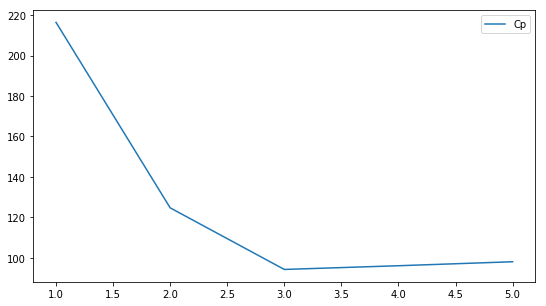

Optimal:
	s* = 3.0
	regressors = [1, 2, 3]

REVERSE
Regressors order: [4 3 2 1 0]


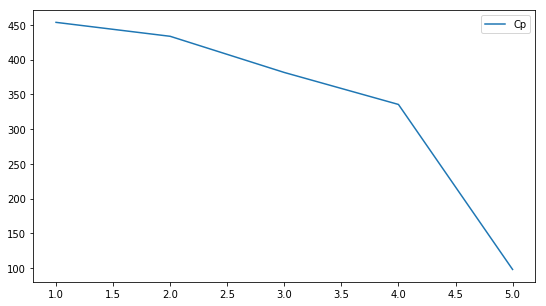

Optimal:
	s* = 5.0
	regressors = [1, 2, 3, 4, 5]


In [772]:
df1 = config1.run_single_RMNK_model_selection(p=None,
                                       criteria=['Cp'],
                                       plot=True)
print()
df2 = config1.run_single_RMNK_model_selection(p='reverse',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 2

DIRECT
Regressors order: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


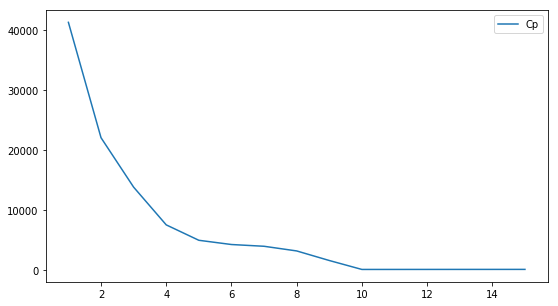

Optimal:
	s* = 10.0
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

REVERSE
Regressors order: [14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


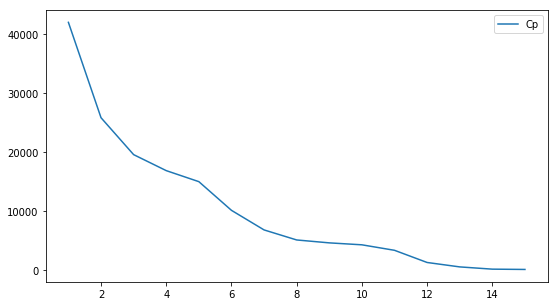

Optimal:
	s* = 15.0
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [773]:
df1 = config2.run_single_RMNK_model_selection(p=None,
                                       criteria=['Cp'],
                                       plot=True)
print()
df2 = config2.run_single_RMNK_model_selection(p='reverse',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 3

DIRECT
Regressors order: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


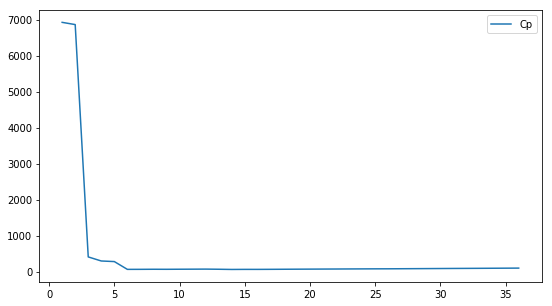

Optimal:
	s* = 14.0
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

REVERSE
Regressors order: [35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12
 11 10  9  8  7  6  5  4  3  2  1  0]


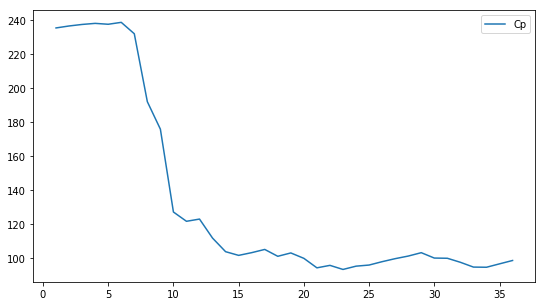

Optimal:
	s* = 23.0
	regressors = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [774]:
df1 = config3.run_single_RMNK_model_selection(p=None,
                                       criteria=['Cp'],
                                       plot=True)
print()
df2 = config3.run_single_RMNK_model_selection(p='reverse',
                                       criteria=['Cp'],
                                       plot=True)

## Пошук моделі. Метод кореляційного включення

### Тест 1

CORRELATION INCLUDING
Regressors order: [0 1 2 4 3]


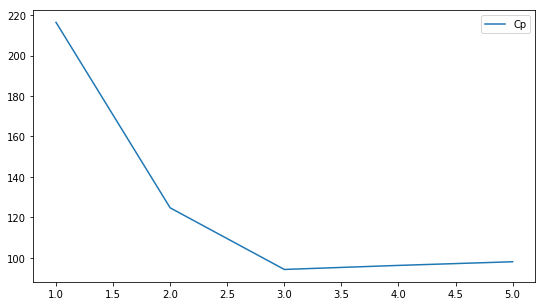

Optimal:
	s* = 3.0
	regressors = [1, 2, 3]


In [775]:
df1 = config1.run_single_RMNK_model_selection(p='correlation',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 2

CORRELATION INCLUDING
Regressors order: [ 3  9  8  2  7  4  1  6  5  0 13 14 12 11 10]


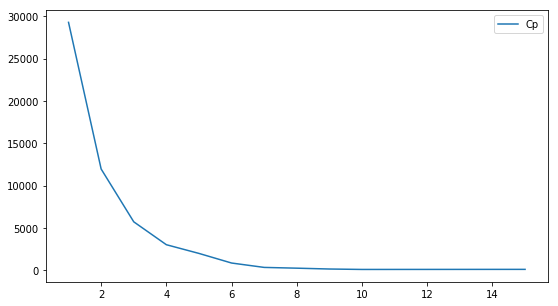

Optimal:
	s* = 10.0
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [776]:
df1 = config2.run_single_RMNK_model_selection(p='correlation',
                                       criteria=['Cp'],
                                       plot=True)

### Тест 3

CORRELATION INCLUDING
Regressors order: [26 24  5  1  6  7  3 28 27 22  8 13 25 11 10 29 18 23 15  2 12 20 19 34
 31 16 33  9 35  4 14 30 32  0 21 17]


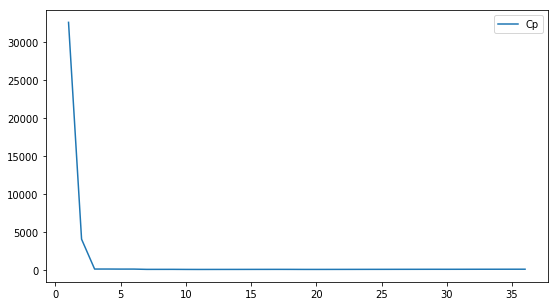

Optimal:
	s* = 11.0
	regressors = [2, 4, 6, 7, 8, 9, 23, 25, 27, 28, 29]


In [777]:
df1 = config3.run_single_RMNK_model_selection(p='correlation',
                                       criteria=['Cp'],
                                       plot=True)

## Пошук моделі. Метод випадкового включення

### Тест 1

In [779]:
Ks = [10, 20, 50]
for K in Ks:
    config1.run_single_random_RMNK_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

    s*      regressors*         Cp
0  5.0  [1, 2, 3, 4, 5]  98.083822
1  5.0  [1, 2, 3, 4, 5]  98.083822
2  5.0  [1, 2, 3, 4, 5]  98.083822
3  5.0  [1, 2, 3, 4, 5]  98.083822
4  4.0     [1, 2, 3, 5]  96.276951
...
    s*      regressors*         Cp
5  3.0        [1, 2, 3]  94.282328
6  5.0  [1, 2, 3, 4, 5]  98.083822
7  4.0     [1, 2, 3, 4]  96.115626
8  4.0     [1, 2, 3, 5]  96.276951
9  4.0     [1, 2, 3, 4]  96.115626

Optimal:
	s* = 3.0
	regressors = [1, 2, 3]
RANDOM INCLUDING WITH K = 20

    s*      regressors*         Cp
0  5.0  [1, 2, 3, 4, 5]  98.083822
1  4.0     [1, 2, 3, 4]  96.115626
2  5.0  [1, 2, 3, 4, 5]  98.083822
3  4.0     [1, 2, 3, 4]  96.115626
4  5.0  [1, 2, 3, 4, 5]  98.083822
...
     s*      regressors*         Cp
15  5.0  [1, 2, 3, 4, 5]  98.083822
16  4.0     [1, 2, 3, 5]  96.276951
17  4.0     [1, 2, 3, 5]  96.276951
18  3.0        [1, 2, 3]  94.282328
19  3.0        [1, 2, 3]  94.282328

Optimal:
	s* = 3.0
	regressors = [1, 2, 3

### Тест 2

In [780]:
Ks = [10, 20, 50]
for K in Ks:
    config2.run_single_random_RMNK_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

     s*                                        regressors*          Cp
0  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
1  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
2  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
3  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
4  14.0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]  114.258229
...
     s*                                        regressors*          Cp
5  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
6  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
7  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
8  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123
9  15.0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  116.237123

Optimal:
	s* = 14.0
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
RANDOM INCLUDING WITH K = 20

 

### Тест 3

In [782]:
Ks = [10, 20, 50, 100]
for K in Ks:
    config3.run_single_random_RMNK_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

     s*                                        regressors*         Cp
0  21.0  [1, 2, 4, 5, 7, 8, 9, 11, 13, 15, 16, 20, 23, ...  75.332316
1  19.0  [1, 2, 5, 7, 9, 13, 16, 18, 19, 22, 24, 25, 27...  82.430653
2  22.0  [1, 2, 3, 4, 5, 6, 10, 11, 13, 15, 17, 20, 21,...  78.091102
3  13.0     [3, 4, 5, 6, 8, 9, 12, 15, 16, 18, 23, 26, 28]  56.085399
4  20.0  [1, 4, 5, 9, 10, 12, 13, 16, 17, 19, 23, 24, 2...  75.436484
...
     s*                                        regressors*         Cp
5   8.0                      [3, 4, 7, 10, 13, 18, 23, 35]  62.258830
6  17.0  [1, 2, 4, 7, 9, 10, 14, 15, 16, 18, 21, 27, 29...  69.731694
7  23.0  [2, 3, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19, 20...  87.231527
8  22.0  [1, 2, 4, 5, 6, 8, 12, 14, 16, 18, 20, 21, 22,...  75.364583
9  24.0  [1, 2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, ...  80.195423

Optimal:
	s* = 13.0
	regressors = [3, 4, 5, 6, 8, 9, 12, 15, 16, 18, 23, 26, 28]
RANDOM INCLUDING WITH K = 20

     s*       

## Пошук моделі. Метод перебірного включення

### Тест 1

In [783]:
total_df, best_df = config1.run_single_picking_RMNK_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')
best_df

PICKING INCLUDING
Optimal:
	s* = 3.0
	regressors = [1, 2, 3]


,s*,regressors*,Cp
0,1.0,[1],216.391532
1,2.0,"[1, 2]",124.724060
2,3.0,"[1, 2, 3]",94.282328
3,3.0,"[1, 2, 3]",94.282328
4,3.0,"[1, 2, 3]",94.282328


In [784]:
total_df

,s,regressors,Cp
0,1.0,[1],216.391532
1,1.0,[2],538.833175
2,1.0,[3],380.129151
3,1.0,[4],450.597581
4,1.0,[5],453.573587
5,2.0,"[1, 2]",124.724060
6,2.0,"[1, 3]",218.131896
7,2.0,"[1, 4]",208.106903
8,2.0,"[1, 5]",209.318742
9,3.0,"[1, 2, 3]",94.282328


### Тест 2

In [795]:
total_df, best_df = config2.run_single_picking_RMNK_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 10.0
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається) 

In [796]:
total_df

,s,regressors,Cp
0,1.0,[1],41354.994466
1,1.0,[2],37630.005797
2,1.0,[3],32941.436205
3,1.0,[4],29282.190223
4,1.0,[5],36730.260511
5,1.0,[6],39343.294431
6,1.0,[7],39495.098730
7,1.0,[8],34653.767187
8,1.0,[9],30581.757867
9,1.0,[10],29854.461825


Таблиця, яка містить глобально кращий результат на кожній ітерації підвищення складності

In [797]:
best_df

,s*,regressors*,Cp
0,1.0,[4],29282.190223
1,2.0,"[4, 10]",11966.835111
2,3.0,"[4, 9, 10]",5730.487062
3,4.0,"[3, 4, 9, 10]",3026.765316
4,5.0,"[3, 4, 5, 9, 10]",1535.515926
5,6.0,"[2, 3, 4, 5, 9, 10]",829.992514
6,7.0,"[2, 3, 4, 5, 8, 9, 10]",346.640527
7,8.0,"[2, 3, 4, 5, 6, 8, 9, 10]",218.295380
8,9.0,"[1, 2, 3, 4, 5, 6, 8, 9, 10]",145.526558
9,10.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",106.550762


### Тест 3

In [798]:
total_df, best_df = config3.run_single_picking_RMNK_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 7.0
	regressors = [3, 4, 5, 6, 9, 16, 26]


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається) 

In [799]:
total_df

,s,regressors,Cp
0,1.0,[1],6922.622699
1,1.0,[2],171607.168945
2,1.0,[3],595.423285
3,1.0,[4],8072.403830
4,1.0,[5],8415.507144
5,1.0,[6],158.358196
6,1.0,[7],175.164569
7,1.0,[8],208501.298773
8,1.0,[9],69222.239836
9,1.0,[10],187787.682459


Таблиця, яка містить глобально кращий результат на кожній ітерації підвищення складності

In [800]:
best_df

,s*,regressors*,Cp
0,1.0,[6],158.358196
1,2.0,"[6, 16]",78.361004
2,3.0,"[4, 6, 16]",54.822413
3,4.0,"[3, 4, 6, 16]",49.481128
4,5.0,"[3, 4, 5, 6, 16]",47.128611
5,6.0,"[3, 4, 5, 6, 9, 16]",45.398392
6,7.0,"[3, 4, 5, 6, 9, 16, 26]",44.912894
7,7.0,"[3, 4, 5, 6, 9, 16, 26]",44.912894
8,7.0,"[3, 4, 5, 6, 9, 16, 26]",44.912894
9,7.0,"[3, 4, 5, 6, 9, 16, 26]",44.912894
